In [1]:
!pip install torchtext==0.15.2 portalocker==2.8.2 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

# LSTM model

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.nn.utils.rnn import pad_sequence
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [4]:
# raw train and test datasets (returns iterator of (label:str, text:str))
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

# convert to list
full_train_raw = list(train_iter)
full_test_raw = list(test_iter)

# split train into train/val (80/20)
train_size = int(0.8 * len(full_train_raw))
val_size = len(full_train_raw) - train_size
train_raw, val_raw = random_split(full_train_raw, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [5]:
# tokenizer and vocab setup
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(text)

# build vocab on training split
vocab = build_vocab_from_iterator(yield_tokens(train_raw), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(f"Vocab size: {len(vocab)}")

Vocab size: 89803


In [6]:
# dataset class
class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.label_map = {'neg': 0, 'pos': 1, 1: 0, 2: 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_raw, text = self.data[idx]
        label = self.label_map[label_raw]
        tokens = tokenizer(text)
        token_ids = torch.tensor(vocab(tokens), dtype=torch.long)
        return token_ids, label

train_dataset = IMDBDataset(train_raw)
val_dataset = IMDBDataset(val_raw)
test_dataset = IMDBDataset(full_test_raw)

In [7]:
# collate batches and pad sequences
def collate_batch(batch):
    token_ids_list, labels = zip(*batch)
    token_ids_padded = pad_sequence(token_ids_list, batch_first=True, padding_value=vocab["<unk>"])
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return token_ids_padded.to(device), labels_tensor.to(device)

# dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 20000
Validation samples: 5000
Test samples: 25000


In [8]:
# text classification model with embedding and mean pooling
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        return self.fc(pooled)

lstm_model = TextClassifier(len(vocab), embed_dim=100, num_classes=2).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# metrics
def accuracy(preds, labels):
    _, pred_classes = torch.max(preds, dim=1)
    return (pred_classes == labels).float().mean().item()

# training and validation
EPOCHS = 35

history_lstm = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(1, EPOCHS + 1):
    lstm_model.train()
    train_loss = 0
    train_acc = 0
    for tokens, labels in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * tokens.size(0)
        train_acc += accuracy(outputs, labels) * tokens.size(0)

    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    lstm_model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for tokens, labels in val_loader:
            outputs = lstm_model(tokens)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * tokens.size(0)
            val_acc += accuracy(outputs, labels) * tokens.size(0)

    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Acc = {train_acc:.4f}; "
          f"Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f}")

    history_lstm['train_loss'].append(train_loss)
    history_lstm['val_loss'].append(val_loss)
    history_lstm['train_acc'].append(train_acc)
    history_lstm['val_acc'].append(val_acc)

# test
lstm_model.eval()
test_loss_lstm = 0
test_acc_lstm = 0
with torch.no_grad():
    for tokens, labels in test_loader:
        outputs = lstm_model(tokens)
        loss = criterion(outputs, labels)
        test_loss_lstm += loss.item() * tokens.size(0)
        test_acc_lstm += accuracy(outputs, labels) * tokens.size(0)

test_loss_lstm /= len(test_dataset)
test_acc_lstm /= len(test_dataset)

print(f"Test Loss = {test_loss_lstm:.4f}, Test Acc = {test_acc_lstm:.4f}")


Epoch 1: Train Loss = 0.6892, Acc = 0.5419; Val Loss = 0.6781, Acc = 0.6310
Epoch 2: Train Loss = 0.6608, Acc = 0.6576; Val Loss = 0.6401, Acc = 0.6788
Epoch 3: Train Loss = 0.6071, Acc = 0.7429; Val Loss = 0.5839, Acc = 0.7462
Epoch 4: Train Loss = 0.5442, Acc = 0.7916; Val Loss = 0.5265, Acc = 0.7966
Epoch 5: Train Loss = 0.4859, Acc = 0.8299; Val Loss = 0.4769, Acc = 0.8214
Epoch 6: Train Loss = 0.4355, Acc = 0.8536; Val Loss = 0.4345, Acc = 0.8474
Epoch 7: Train Loss = 0.3915, Acc = 0.8752; Val Loss = 0.4026, Acc = 0.8574
Epoch 8: Train Loss = 0.3564, Acc = 0.8873; Val Loss = 0.3750, Acc = 0.8700
Epoch 9: Train Loss = 0.3265, Acc = 0.8995; Val Loss = 0.3542, Acc = 0.8720
Epoch 10: Train Loss = 0.3021, Acc = 0.9079; Val Loss = 0.3383, Acc = 0.8790
Epoch 11: Train Loss = 0.2808, Acc = 0.9141; Val Loss = 0.3256, Acc = 0.8786
Epoch 12: Train Loss = 0.2638, Acc = 0.9190; Val Loss = 0.3143, Acc = 0.8828
Epoch 13: Train Loss = 0.2470, Acc = 0.9244; Val Loss = 0.3061, Acc = 0.8870
Epoch 14

# Transformer encoder model

In [10]:
import re
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
# preprocessing
tokenizer = get_tokenizer("basic_english")

def clean_text(text):
    return re.sub(r"<[^>]+>", "", text)

def yield_tokens(data_iter):
    for label, text in data_iter:
        yield tokenizer(clean_text(text))

train_iter = IMDB(split='train')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])
pad_idx = vocab["<pad>"]

In [12]:
# dataset
class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.label_map = {'neg': 0, 'pos': 1, 1: 0, 2: 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_raw, text = self.data[idx]
        label = self.label_map[label_raw]
        tokens = tokenizer(clean_text(text))
        token_ids = torch.tensor(vocab(tokens), dtype=torch.long)
        return token_ids, label

In [13]:
# data preparation
full_train_raw = list(IMDB(split='train'))
full_test_raw = list(IMDB(split='test'))

train_size = int(0.8 * len(full_train_raw))
val_size = len(full_train_raw) - train_size
train_raw, val_raw = random_split(full_train_raw, [train_size, val_size])

train_dataset = IMDBDataset(train_raw)
val_dataset = IMDBDataset(val_raw)
test_dataset = IMDBDataset(full_test_raw)

def collate_batch(batch):
    token_ids_list, labels = zip(*batch)
    token_ids_padded = pad_sequence(token_ids_list, batch_first=True, padding_value=pad_idx)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return token_ids_padded.to(device), labels_tensor.to(device)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 20000
Validation samples: 5000
Test samples: 25000


In [14]:
# transformer encoder model
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=8, hidden_dim=256, num_layers=2, dropout=0.2, max_len=5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, nhead, hidden_dim, dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, 2)

    def forward(self, x):
        x = self.embedding(x) + self.pos_encoder[:, :x.size(1)]
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.mean(dim=0)
        return self.fc(x)

transformer_model = TransformerClassifier(
    len(vocab),
    embed_dim=32,
    nhead=4,
    hidden_dim=128,
    num_layers=1
).to(device)

In [15]:
# training and evaluation
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=1e-3)

history_transformer = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

def evaluate_model(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch}: Train Loss = {total_loss / total:.4f}, Acc = {train_acc:.4f}; "
              f"Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f}")

        history_transformer['train_loss'].append(total_loss / total)
        history_transformer['val_loss'].append(val_loss)
        history_transformer['train_acc'].append(train_acc)
        history_transformer['val_acc'].append(val_acc)

# run and test
train_model(transformer_model, train_loader, val_loader, num_epochs=10)
test_loss_transformer, test_acc_transformer = evaluate_model(transformer_model, test_loader)
print(f"Test Loss = {test_loss_transformer:.4f}, Test Acc = {test_acc_transformer:.4f}")

Epoch 1: Train Loss = 0.5403, Acc = 0.7089; Val Loss = 0.4163, Acc = 0.8102
Epoch 2: Train Loss = 0.3274, Acc = 0.8618; Val Loss = 0.3355, Acc = 0.8574
Epoch 3: Train Loss = 0.2251, Acc = 0.9106; Val Loss = 0.3309, Acc = 0.8576
Epoch 4: Train Loss = 0.1544, Acc = 0.9425; Val Loss = 0.3860, Acc = 0.8686
Epoch 5: Train Loss = 0.1021, Acc = 0.9641; Val Loss = 0.4562, Acc = 0.8642
Epoch 6: Train Loss = 0.0607, Acc = 0.9797; Val Loss = 0.5122, Acc = 0.8636
Epoch 7: Train Loss = 0.0352, Acc = 0.9892; Val Loss = 0.7341, Acc = 0.8562
Epoch 8: Train Loss = 0.0219, Acc = 0.9932; Val Loss = 0.8388, Acc = 0.8604
Epoch 9: Train Loss = 0.0145, Acc = 0.9950; Val Loss = 0.9716, Acc = 0.8534
Epoch 10: Train Loss = 0.0093, Acc = 0.9972; Val Loss = 1.0760, Acc = 0.8536
Test Loss = 1.3208, Test Acc = 0.8314


# Plots and comparison

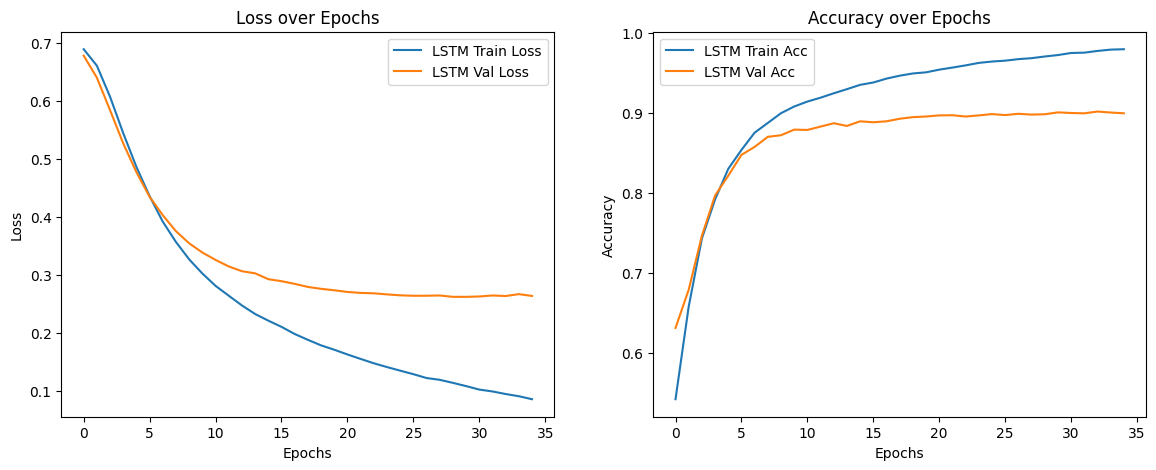

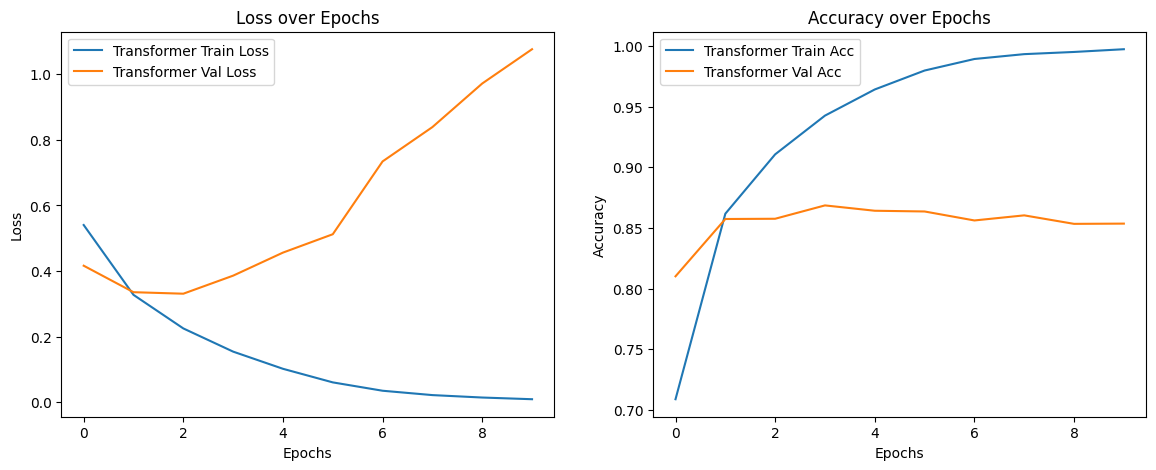

In [16]:
# plot training and validation curves for both models
import matplotlib.pyplot as plt

def plot_curves(history, label):
    plt.figure(figsize=(14, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label=f'{label} Train Loss')
    plt.plot(history['val_loss'], label=f'{label} Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label=f'{label} Train Acc')
    plt.plot(history['val_acc'], label=f'{label} Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_curves(history_lstm, "LSTM")
plot_curves(history_transformer, "Transformer")

In [17]:
import pandas as pd

In [18]:
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'Transformer'],
    'Test Accuracy': [test_acc_lstm, test_acc_transformer],
    'Train Accuracy (last epoch)': [history_lstm['train_acc'][-1], history_transformer['train_acc'][-1]],
    'Validation Accuracy (last epoch)': [history_lstm['val_acc'][-1], history_transformer['val_acc'][-1]]
})

print("\nModel Performance Comparison:\n")
display(comparison_df)


Model Performance Comparison:



,Model,Test Accuracy,Train Accuracy (last epoch),Validation Accuracy (last epoch)
0,LSTM,0.89012,0.97955,0.8994
1,Transformer,0.83144,0.99725,0.8536
